The active learning data can be implemented as:
1. Using lists and Subset()
2. Implementing a active learning data set class that splits the data into a unlabeled pool and the labeled pool.
    - I need a mask to indicate which points have been labeled.
    - The mask is reset at the beginning of the AL run and then updated each AL step to include the newly queried data points.

In [55]:
import os
os.chdir('/Users/madsbirch/Documents/bal')
print("Current working directory: {0}".format(os.getcwd()))

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
%autoreload 2

Current working directory: /Users/madsbirch/Documents/bal
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import time 
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_circles, make_classification
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from tqdm import tqdm

import pickle

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.utils.data import DataLoader, Subset

from src.models.model import AL_Model, TwoMoons_Model, PaperCNN
from src.data.data import get_dataloaders, TwoMoons
from src.models.train_model import train, test
from src.features.utils import softmax_grid, accuracy, predict, BALD_grid_viz
from src.features.acquistion_functions import query_the_oracle, random_query
from src.features.sampling import Sampling

from netcal.metrics import ECE
from torchmetrics import CalibrationError
from torchmetrics.classification import BinaryCalibrationError

from tqdm import tqdm


torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.benchmark = True

# Set device
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = 'cpu'
print(f"Using device: {device}")

FIGURE_PATH = '/Users/madsbirch/Documents/bal/reports/figures/'


Using device: cpu


In [57]:
from src.data.data import ActiveLearningDataset, get_balanced_sample_indices, get_targets
from src.data.data import TwoMoons, MNIST_CUSTOM

# Initialize the dataset.
X, y = make_moons(n_samples = 1000, noise = 0.15, random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

twomoons_traindata = TwoMoons(X_train, y_train, return_idx = True)
twomoons_testdata = TwoMoons(X_test, y_test, return_idx = True)


### calculting the grid
xlim_neg = X_train[:,0].min()-1
xlim_pos = X_train[:,0].max()+1
ylim_neg = X_train[:,1].min()-1
ylim_pos = X_train[:,1].max()+1


# Generates the initial balanced pool.
# define how many classes there is in the data and how many samples per class you want.
n_classes = 2
n_init_samples = 10


initial_samples = get_balanced_sample_indices(
    get_targets(twomoons_traindata),
    num_classes=n_classes,
    n_per_digit=n_init_samples / n_classes,
)

init_samples = {'idxs': initial_samples}
with open("init_samples", "wb") as fp:
    pickle.dump(init_samples, fp)

In [58]:
with open("/Users/madsbirch/Documents/bal/init_samples", 'rb') as f:
    init_samples_dict = pickle.load(f)

init_sample_idxs = init_samples_dict['idxs']

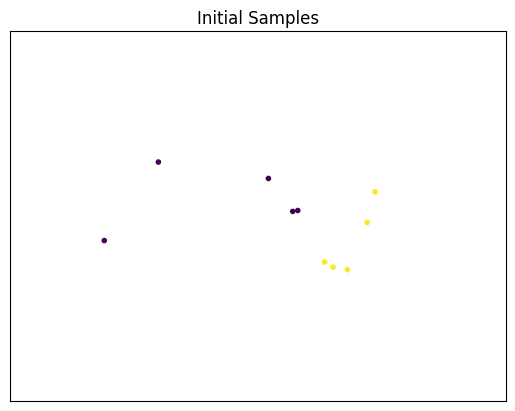

In [59]:
plt.scatter(X_train[init_sample_idxs,0], X_train[init_sample_idxs,1], c = y_train[init_sample_idxs], marker = '.') # to set markers to digits for each query step, put in a for loop and use the index in the marker definition.
plt.xlim(xlim_neg, xlim_pos,)
plt.ylim(ylim_neg, ylim_pos)
plt.xticks([])
plt.yticks([])
plt.title("Initial Samples")
plt.show()

## Plotting Learning Curves

100%|██████████| 4/4 [03:51<00:00, 57.90s/it] 


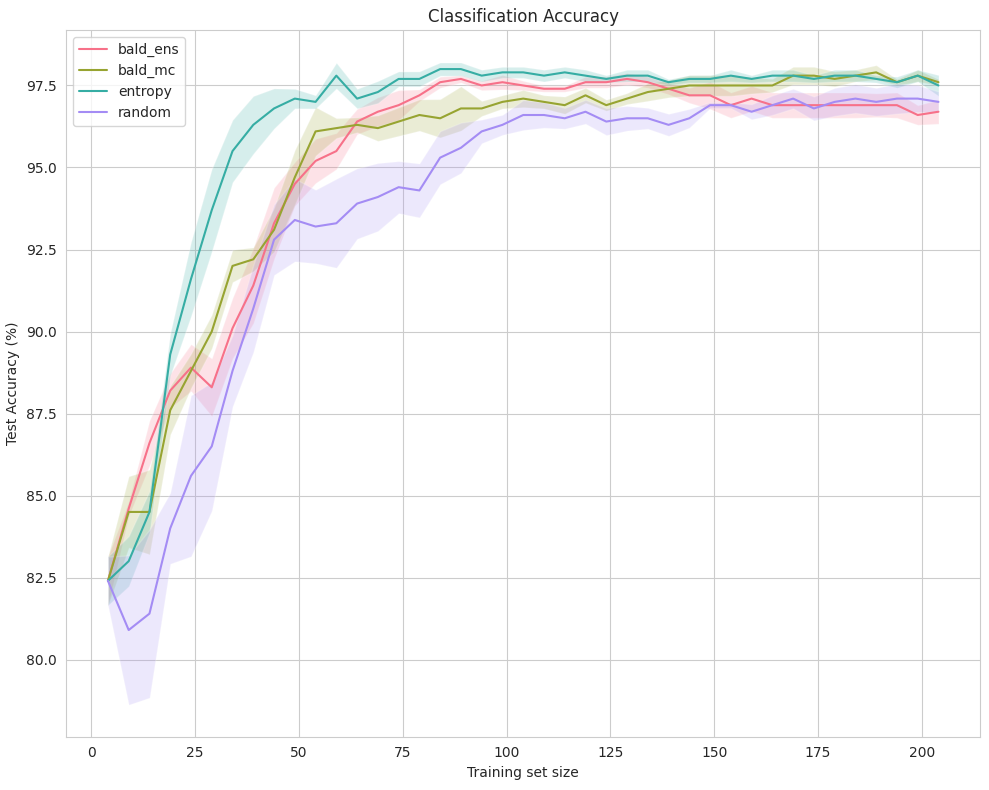

In [7]:
# parameters
lr = 1e-3
batch_size = 500
dropout = 0.3
n_epochs = 100
query_size = 5
n_iter = 5
n_queries = 40
n_drop = 30
n_ens = 5

max_training_samples = 100
sampling_strat = 'margin'
strat_list = ['bald_ens','bald_mc', 'entropy', 'random']

# lists and dictionaries for storage of performance metrics
bce_metric = CalibrationError(n_bins = 15, task = 'binary')
TEST_ACC = np.zeros((n_iter, n_queries+1))
TEST_ECE = np.zeros((n_iter, n_queries+1))


test_dict = {
    'random': {'acc_mean': [], 'acc_se': [], 'bce_mean': [], 'bce_se': [],'dataset_len': []},
    'margin': {'acc_mean': [], 'acc_se': [], 'bce_mean': [], 'bce_se': [], 'dataset_len': []},
    'entropy': {'acc_mean': [], 'acc_se': [], 'bce_mean': [], 'bce_se': [], 'dataset_len': []},
    'bald_mc': {'acc_mean': [], 'acc_se': [], 'bce_mean': [], 'bce_se': [], 'dataset_len': []},
    'bald_ens': {'acc_mean': [], 'acc_se': [], 'bce_mean': [], 'bce_se': [], 'dataset_len': []},
}


for s in tqdm(strat_list):
    #print(f'STRATEGY: {s}')
    for i in range(n_iter):
        #print(f'ITER: {i+1:2d}')
        
        torch.manual_seed(i)
        np.random.seed(i)
        random.seed(i)

        # define model and optimizer
        twomoons_net = TwoMoons_Model(dropout=dropout)
        al_model = AL_Model(twomoons_net, device)

        # Initalize the Active Learning Dataset s.t. the training set is empty and the unlabaled pool is full.
        # Acquire the initial pool to the traindata.
        al_traindata = ActiveLearningDataset(twomoons_traindata)
        al_traindata.acquire_samples(init_sample_idxs)

        # n_queries + 1 because of initial pool
        for q in range(n_queries+1):

            ## train modelx
            al_model.train(al_traindata.labeled_dataset, n_epochs=n_epochs, lr=lr)    
            
            ## test model
            acc, ece = al_model.test(twomoons_testdata)
            TEST_ACC[i,q] = acc
            TEST_ECE[i,q] = ece
            
            # random way to 
            if i == 0:
                test_dict[s]["dataset_len"].append(len(al_traindata.labeled_dataset))
            
            if s == "random":
                batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).random()
            
            if s == "margin":
                batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).margin()

            if s == "entropy":
                batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).entropy()
            
            if s == "bald_mc":
                batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).bald_mc(n_drop=n_drop)
            
            if s == "bald_ens":
                batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).bald_ensemble(traindata = al_traindata.labeled_dataset, n_ens = n_ens, n_epochs = n_epochs, lr = lr)
                
            al_traindata.acquire_samples(batch.indices)
                    
    test_dict[s]['acc_se'] = TEST_ACC.std(0)/np.sqrt(n_iter)
    test_dict[s]['acc_mean']  = TEST_ACC.mean(0)
    test_dict[s]['bce_mean']  = TEST_ECE.mean(0)
    test_dict[s]['bce_se'] = TEST_ECE.std(0)/np.sqrt(n_iter)
    
    
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(10,8))  # Adjusted to create a single subplot

    x = np.linspace(start=n_init_samples,
                    stop=n_init_samples + n_queries * query_size, 
                    num=n_queries + 1, 
                    dtype=int)
    
    clrs = sns.color_palette("husl", len(strat_list))
    for i, s in enumerate(strat_list):
        acc_mean = test_dict[s]['acc_mean']
        acc_std = test_dict[s]['acc_se']
        ax1.plot(x, acc_mean, label=s, c=clrs[i])
        ax1.fill_between(x, acc_mean + acc_std, acc_mean - acc_std, alpha=0.2, facecolor=clrs[i])
        ax1.legend()
        ax1.set_title('Classification Accuracy')
        ax1.set_xlabel('Training set size')
        ax1.set_ylabel('Test Accuracy (%)')
        # ax1.tick_params('x', labelrotation=x_tick_rot)  # Uncomment if rotation is needed

    fig.savefig('reports/figures/TwoMoons_results_5.png')  # Save the figure
    fig.tight_layout()

In [ ]:
mnist_train_data = 100
mnist_test_data = 20

# choose acquiistion function, number of queries and the query batch size
sampling_strat = 'margin'
num_queries = 20
query_size = 4

# define model and turn it into an AL model
model = PaperCNN()
al_model = AL_Model(model, device)

# Initalize the AL dataset s.t. the training set is empty and the unlabaled pool is full
al_traindata = ActiveLearningDataset(mnist_train_data)
al_traindata.acquire_samples(init_sample_idxs) # Acquire the initial pool to the traindata.

# start AL loop
for q in tqdm(range(num_queries+1)):

    ## train model
    al_model.train(al_traindata.labeled_dataset, n_epochs=n_epochs, lr=lr)    
    
    ## test model
    acc = al_model.test(mnist_test_data)
    
    # choose acquisition function
    if sampling_strat == "random":
        batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).random()
    
    elif sampling_strat == "margin":
        batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).margin()

    elif sampling_strat == "entropy":
        batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).entropy()
    
    elif sampling_strat == "bald_mc":
        batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).bald_mc(n_drop=n_drop)
    
    elif sampling_strat == "bald_ens":
        batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).bald_ensemble(traindata = al_traindata.labeled_dataset, n_ens = n_ens, n_epochs = n_epochs, lr = lr)
    
    # acquire new samples
    al_traindata.acquire_samples(batch.indices)

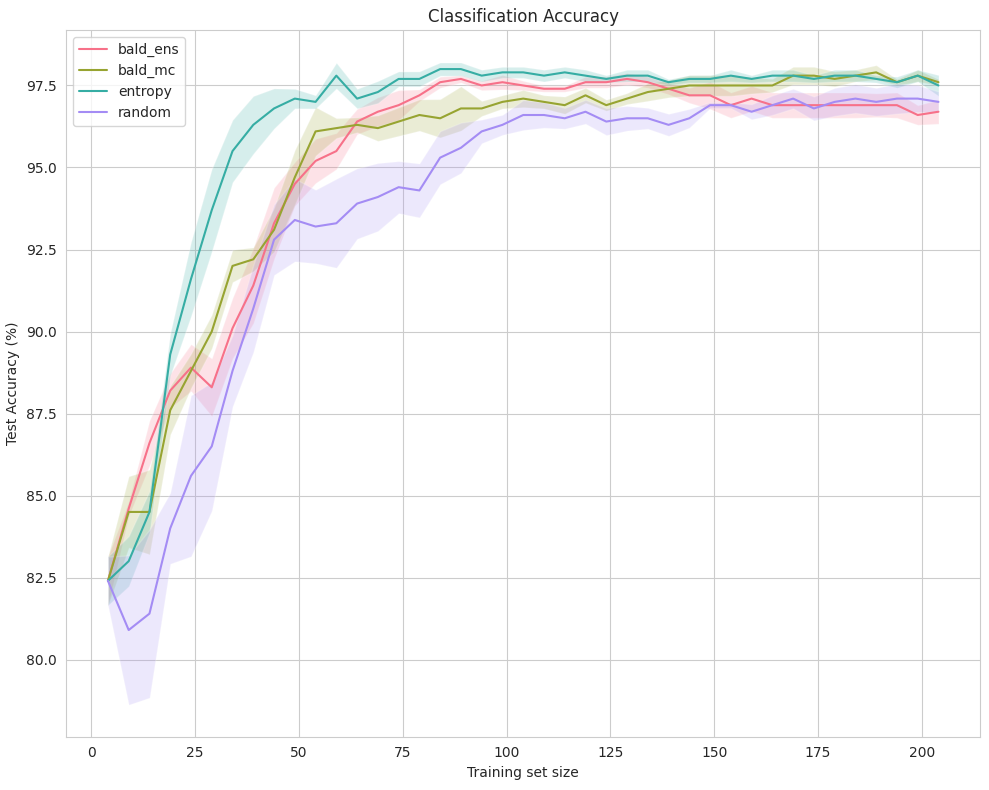

In [11]:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(10,8))  # Adjusted to create a single subplot

    x = np.linspace(start=n_init_samples,
                    stop=n_init_samples + n_queries * query_size, 
                    num=n_queries + 1, 
                    dtype=int)
    
    clrs = sns.color_palette("husl", len(strat_list))
    for i, s in enumerate(strat_list):
        acc_mean = test_dict[s]['acc_mean']
        acc_std = test_dict[s]['acc_se']
        ax1.plot(x, acc_mean, label=s, c=clrs[i])
        ax1.fill_between(x, acc_mean + acc_std, acc_mean - acc_std, alpha=0.2, facecolor=clrs[i])
        ax1.legend()
        ax1.set_title('Classification Accuracy')
        ax1.set_xlabel('Training set size')
        ax1.set_ylabel('Test Accuracy (%)')
        # ax1.tick_params('x', labelrotation=x_tick_rot)  # Uncomment if rotation is needed

    fig.savefig('reports/figures/TwoMoons_results_5.png')  # Save the figure
    fig.tight_layout()

## Visualizing in 2D

bald_mc
entropy
margin
random


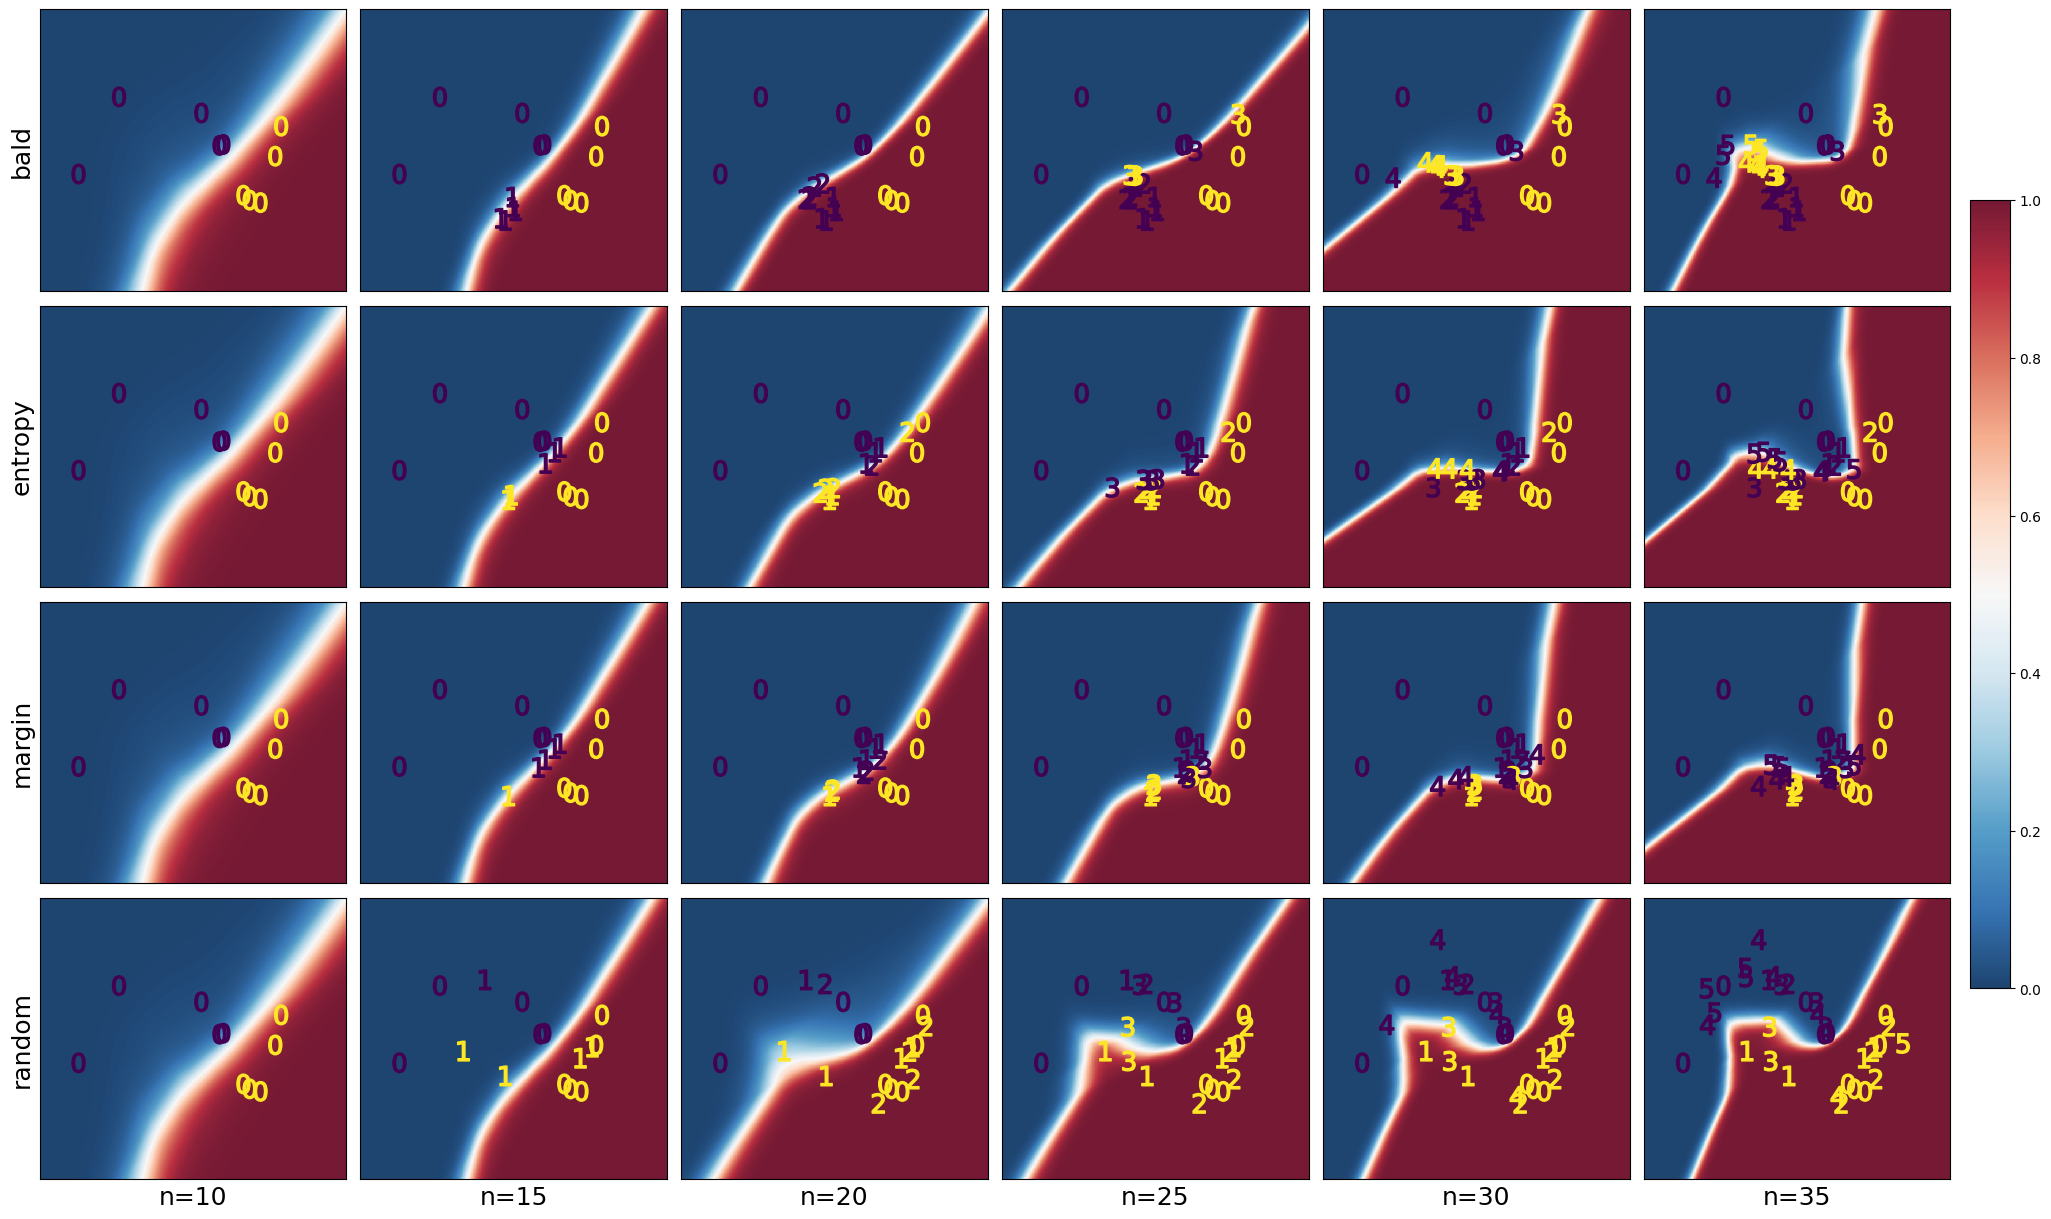

In [60]:
MODEL_PATH = '/Users/madsbirch/Documents/bal/models/'

# parameters
lr = 1e-3
batch_size = 500
dropout = 0.3
n_epochs = 150
query_size = 5
n_queries = 5

n_drop = 100
n_ens = 5

mesh_alpha = 0.9

# Larger figure and marker sizes for better visibility
figsize = (20, 12)  # Larger figure size for subplots
marker_size = 200  # Size of the markers

# figure initialization with adjusted figsize
strat_list = ['bald_mc', 'entropy', 'margin','random']
labels = ['bald', 'entropy', 'margin','random']
fig, axs = plt.subplots(nrows=len(strat_list), figsize=figsize, ncols=n_queries+1, sharex=True, sharey=True)

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.benchmark = True



# Define model and optimizer
twomoons_net = TwoMoons_Model(dropout=dropout)
al_model = AL_Model(twomoons_net, device)

# Initialize the Active Learning Dataset
al_traindata = ActiveLearningDataset(twomoons_traindata)
al_traindata.acquire_samples(init_sample_idxs)

al_model.train(al_traindata.labeled_dataset, n_epochs=n_epochs, lr=lr)

# save model state for the common model. Will be reloaded in the loop below. 
state = {
'state_dict': al_model.model.state_dict()
}
torch.save(state, MODEL_PATH+'plot_model.pth')

# Initialize a list to keep track of indices acquired at each step for all strategies
acquired_indices_per_strat = [[] for _ in strat_list]

for i, s in enumerate(strat_list):
    print(s)

    # Define model and optimizer
    twomoons_net = TwoMoons_Model(dropout=dropout)
    al_model = AL_Model(twomoons_net, device)
    state = torch.load(MODEL_PATH+'plot_model.pth')
    al_model.model.load_state_dict(state['state_dict'])

    # Initialize the Active Learning Dataset
    al_traindata = ActiveLearningDataset(twomoons_traindata)
    al_traindata.acquire_samples(init_sample_idxs)
    
    # Save initial indices for plotting
    acquired_indices_per_strat[i].append(init_sample_idxs)
    
    # Plot initial points with marker 0
    xx, yy, softmax_out = softmax_grid(al_model.model, X_train, y_train)
    mesh = axs[i,0].pcolormesh(xx, yy, softmax_out, cmap=plt.cm.RdBu_r, alpha=mesh_alpha, vmin=0, vmax=1)
    axs[i,0].scatter(X_train[init_sample_idxs,0], X_train[init_sample_idxs,1], c=y_train[init_sample_idxs], marker='$0$', s=marker_size)
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    
    for q in range(1, n_queries + 1):
        # Train model
        al_model.train(al_traindata.labeled_dataset, n_epochs=n_epochs, lr=lr)
        
        # Strategy-specific sampling
        batch_indices = None
        if s == "random":
            batch_indices = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).random().indices
        elif s == "margin":
            batch_indices = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).margin().indices
        elif s == "entropy":
            batch_indices = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).entropy().indices
        elif s == "bald_mc":
            batch_indices = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).bald_mc(n_drop=n_drop).indices
        
        if batch_indices is not None:
            al_traindata.acquire_samples(batch_indices)
            acquired_indices_per_strat[i].append(batch_indices)

        # Plotting all points up to the current query with appropriate markers
        xx, yy, softmax_out = softmax_grid(al_model.model, X_train, y_train)  # Recalculate for updated model
        axs[i, q].pcolormesh(xx, yy, softmax_out, cmap=plt.cm.RdBu_r, alpha=mesh_alpha, vmin=0, vmax=1)  # Redraw background
        for marker_index, indices in enumerate(acquired_indices_per_strat[i]):
            marker_style = f'${marker_index}$'
            #axs[i, q].scatter(X_train[:,0], X_train[:,1], c = y_train, alpha = 0.1,s=marker_size/2)
            axs[i, q].scatter(X_train[indices, 0], X_train[indices, 1], c=y_train[indices], marker=marker_style, s=marker_size)
            
        
        axs[i, q].set_xticks([])
        axs[i, q].set_yticks([])

# Adjustments for larger subplots and markers
fig.tight_layout()
fig.colorbar(mesh, ax=axs.ravel().tolist(), fraction=0.02, pad=0.01)
#fig.suptitle('Model Decision Boundaries for Various Acquisition Functions', size=30)
for i, strat in enumerate(labels):
    axs[i,0].set_ylabel(strat, fontsize=18)
ns = np.linspace(0, query_size * n_queries, n_queries + 1, dtype=int)
for i, n in enumerate(ns):
    axs[len(strat_list)-1,i].set_xlabel(f'n={int(n_init_samples+n)}', fontsize=18)

plt.savefig(FIGURE_PATH + 'dec_bound_1.png')
plt.show()


## BALD terms viz

// Query  1 of size 5
[array([424, 774, 756,  16,  69])]
// Query  2 of size 5
[array([424, 774, 756,  16,  69]), array([625, 130, 566, 573, 346])]
// Query  3 of size 5
[array([424, 774, 756,  16,  69]), array([625, 130, 566, 573, 346]), array([348, 595,  20, 539, 273])]
// Query  4 of size 5
[array([424, 774, 756,  16,  69]), array([625, 130, 566, 573, 346]), array([348, 595,  20, 539, 273]), array([333, 285, 239, 778, 211])]
// Query  5 of size 5
[array([424, 774, 756,  16,  69]), array([625, 130, 566, 573, 346]), array([348, 595,  20, 539, 273]), array([333, 285, 239, 778, 211]), array([ 33, 243, 736, 512, 470])]


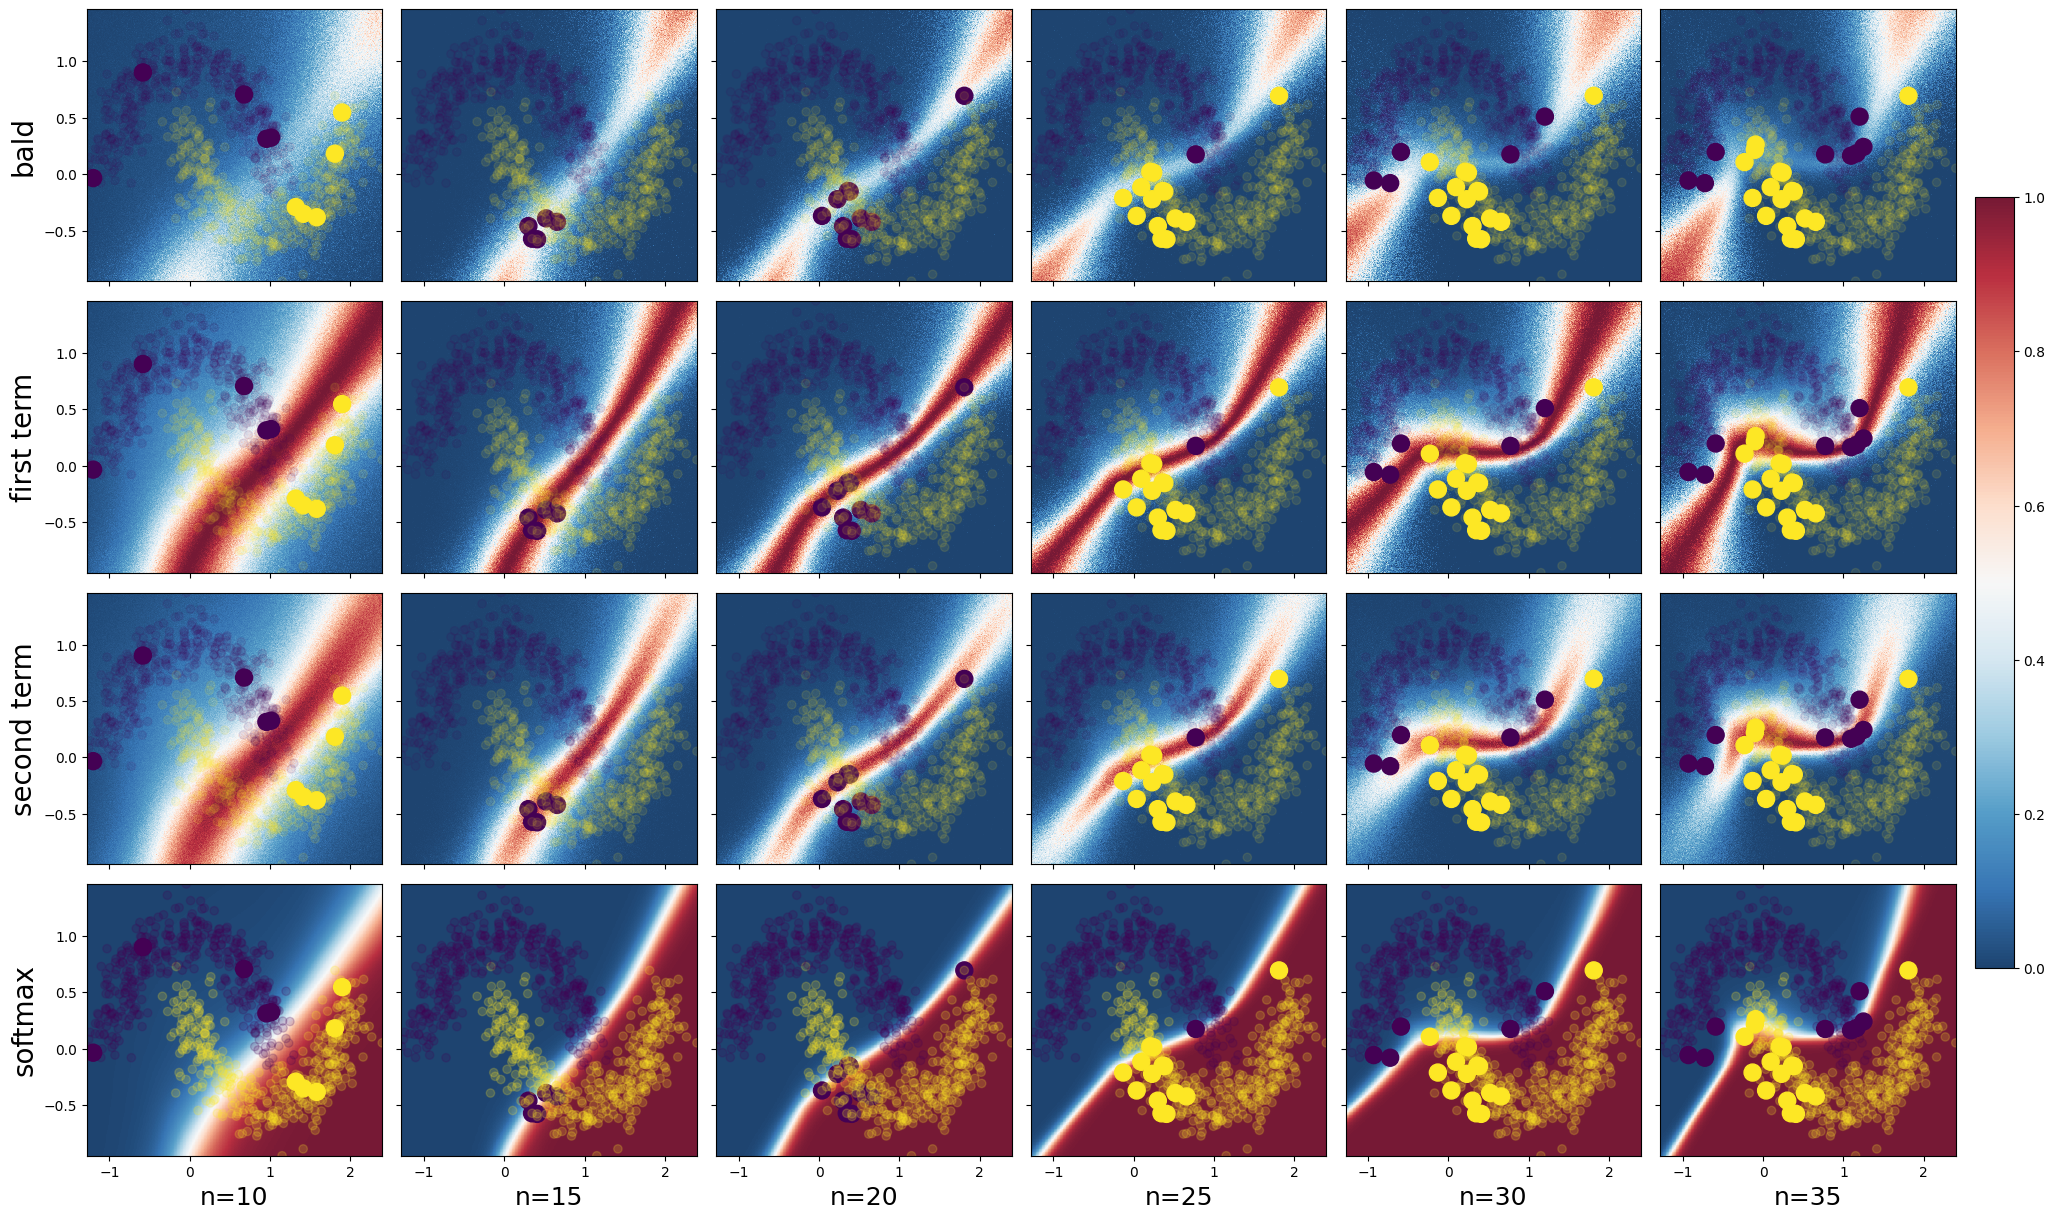

In [62]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.benchmark = True

# parameters
lr = 1e-3
batch_size = 500
dropout = 0.3
n_epochs = 150
query_size = 5
num_queries = 5

n_drop = 100
n_ens = 5

mesh_alpha = 0.9

# Larger figure and marker sizes for better visibility
figsize = (20, 12)  # Larger figure size for subplots
marker_size = 150  # Size of the markers

label_list = ['bald', 'first term', 'second term', 'softmax']
acquired_indices = []
bald_out_list = []
s = 'bald_mc'

# figure init
fig, axs = plt.subplots(nrows=len(label_list), ncols=num_queries+1, figsize=figsize,sharex=True, sharey=True)

# Define model and optimizer
twomoons_net = TwoMoons_Model(dropout=dropout)
al_model = AL_Model(twomoons_net, device)
state = torch.load(MODEL_PATH+'plot_model.pth')
al_model.model.load_state_dict(state['state_dict'])

# Initialize the Active Learning Dataset
al_traindata = ActiveLearningDataset(twomoons_traindata)
al_traindata.acquire_samples(init_sample_idxs)

# plot initial 10 data points, first col in plot
xx, yy, grids_list = BALD_grid_viz(al_model.model, X_train, y_train, T = n_drop)
xx_soft, yy_soft, softmax_out = softmax_grid(al_model.model, X_train, y_train)

for i, g in enumerate(grids_list):
    mesh = axs[i,0].pcolormesh(xx, yy, g, cmap=plt.cm.RdBu_r, alpha = mesh_alpha)
    axs[i,0].scatter(X_train[init_sample_idxs,0], X_train[init_sample_idxs,1], c= y_train[init_sample_idxs], s=marker_size)
    axs[i,0].scatter(X_train[:,0], X_train[:,1], c = y_train, alpha = 0.1)
    axs[i,0].set_xlim(X_train[:,0].min(), X_train[:,0].max())
    axs[i,0].set_ylim(X_train[:,1].min(), X_train[:,1].max())
    
mesh = axs[3,0].pcolormesh(xx_soft, yy_soft, softmax_out, cmap=plt.cm.RdBu_r, alpha = mesh_alpha)
axs[3,0].scatter(X_train[init_sample_idxs,0], X_train[init_sample_idxs,1], c = y_train[init_sample_idxs],s=marker_size)
axs[3,0].scatter(X_train[:,0], X_train[:,1], c = y_train, alpha = 0.2)
axs[3,0].set_xlim(X_train[:,0].min(), X_train[:,0].max())
axs[3,0].set_ylim(X_train[:,1].min(), X_train[:,1].max())


for j, query in enumerate(range(num_queries)):
    print(f'// Query {j+1:2d} of size {query_size}')
    
    # Train model
    al_model.train(al_traindata.labeled_dataset, n_epochs=n_epochs, lr=lr)
    
    # Strategy-specific sampling
    batch_indices = None
    if s == "random":
        batch_indices = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).random().indices
    elif s == "margin":
        batch_indices = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).margin().indices
    elif s == "entropy":
        batch_indices = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).entropy().indices
    elif s == "bald_mc":
        batch_indices = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).bald_mc(n_drop=n_drop).indices
    
    if batch_indices is not None:
        al_traindata.acquire_samples(batch_indices)
        acquired_indices.append(batch_indices)
    
    flat_acquired_indices = [idx for sublist in acquired_indices for idx in sublist]
    print(acquired_indices)
     # plot
    xx, yy, grids_list = BALD_grid_viz(al_model.model, X_train, y_train, T = n_drop)
    xx_soft, yy_soft, softmax_out = softmax_grid(al_model.model, X_train, y_train)
    
    bald_out_list.append(grids_list[0])
    
    for k, g in enumerate(grids_list):
        mesh = axs[k,j+1].pcolormesh(xx, yy, g, cmap=plt.cm.RdBu_r, alpha = mesh_alpha)
        axs[k,j+1].scatter(X_train[flat_acquired_indices,0], X_train[flat_acquired_indices,1], c = y_train[flat_acquired_indices], s=marker_size)
        axs[k,j+1].scatter(X_train[:,0], X_train[:,1], c = y_train, alpha = 0.1)
        axs[k,j+1].set_xlim(X_train[:,0].min(), X_train[:,0].max())
        axs[k,j+1].set_ylim(X_train[:,1].min(), X_train[:,1].max())
    
    mesh = axs[3,j+1].pcolormesh(xx_soft, yy_soft, softmax_out, cmap=plt.cm.RdBu_r, alpha = mesh_alpha)
    axs[3,j+1].scatter(X_train[flat_acquired_indices,0], X_train[flat_acquired_indices,1], c = y_train[flat_acquired_indices],s=marker_size)
    axs[3,j+1].scatter(X_train[:,0], X_train[:,1], c = y_train, alpha = 0.2)
    axs[3,j+1].set_xlim(X_train[:,0].min(), X_train[:,0].max())
    axs[3,j+1].set_ylim(X_train[:,1].min(), X_train[:,1].max())
    
    
fig.tight_layout()
fig.colorbar(mesh, ax=axs.ravel().tolist(), fraction=0.02, pad=0.01)

# set ylabels to strategy
for i, label in enumerate(label_list):
    axs[i,0].set_ylabel(label, fontsize=20)

ns = np.linspace(0, query_size * n_queries, n_queries + 1, dtype=int)
for i, n in enumerate(ns):
    axs[len(strat_list)-1,i].set_xlabel(f'n={int(n_init_samples+n)}', fontsize=18)

plt.savefig(FIGURE_PATH+'bald_viz_3.png')
plt.show()